## SVM eMail Spam Classifier

Many email services today provide spam filters that are able to classify emails into spam and non-spam email with high accuracy. In this part of the playground, we will use SVMs to build your own spam filter!

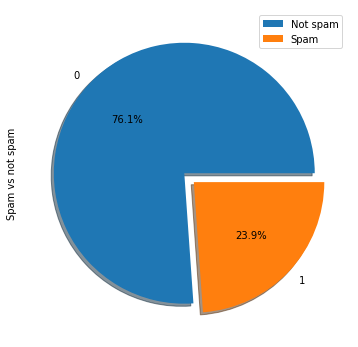

In [5]:
df = pd.read_csv('emails.csv')
df['spam'].value_counts().plot(kind = 'pie', explode = [0, 0.1], figsize = (6, 6), autopct = '%1.1f%%', shadow = True)
plt.ylabel("Spam vs not spam")
plt.legend(["Not spam", "Spam"])
plt.show()

### Functions

In [6]:
import email
import os
import re, cgi
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize


# reads the fixed vocabulary list in vocab.txt and returns a cell array of the words in vocabList
def get_vocabList():
    vocab = pd.read_table('vocab.txt', delim_whitespace=True, header=None)
    vocab = vocab.iloc[:,-1].values.tolist()
    return vocab
       

# preprocesses the body of an email and returns a list of indices of the words contained in the email
def process_email(email, is_file):
    
    # read email from a file is `is_file` is True, otherwise the parameter email is directly passed as a string 
    if is_file == True:
        with open(email, 'r', encoding='ISO-8859-1') as myfile:
            processed_email = myfile.read()
            original_email = processed_email
    else:
        processed_email = email
        original_email = email
            
    vocabList = get_vocabList()
    
    
    # set all character in lower case
    processed_email = str(processed_email).lower()

    # strip all HTML
    processed_email = re.sub('<[^<]+?>', '', processed_email)

    # replace any number into the string 'number'
    processed_email = re.sub('[0-9]+', 'number ', processed_email) 

    # replace strings starting with http:// or https:// with the string 'httpaddr'
    processed_email = re.sub('(http|https)://[^\s]*', 'httpaddr ', processed_email) 

    # replace email with string 'emailaddr'
    processed_email = re.sub('[^\s]+@[^\s]+', 'emailaddr ', processed_email) 

    # replace dollar sign ($) with string 'dollar'
    processed_email = re.sub('[$]+', 'dollar ', processed_email) 
    
    # delete non-alphanumeric characters
    processed_email = re.sub('[^a-zA-Z0-9]', ' ', processed_email)
    
    word_indices = np.array([])
    for word in processed_email.split():
        ps = PorterStemmer()
        # stem the word
        word = ps.stem(word)
        
        # if the word is in vocabList, insert in word_indices array the word's index of vocabList 
        for index in range(len(vocabList)):
            if vocabList[index] == word:
                word_indices = np.append(word_indices, index)
    return word_indices, original_email, vocabList, processed_email


# takes in a word_indices vector and produces a feature vector from the word indices
def email_feature(word_indices, vocabList):
    x = np.zeros(len(vocabList))
    for index in range(len(word_indices)):
        x[int(word_indices[index])] = 1
    return x

/home/pptr/.conda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  # Remove the CWD from sys.path while we load stuff.


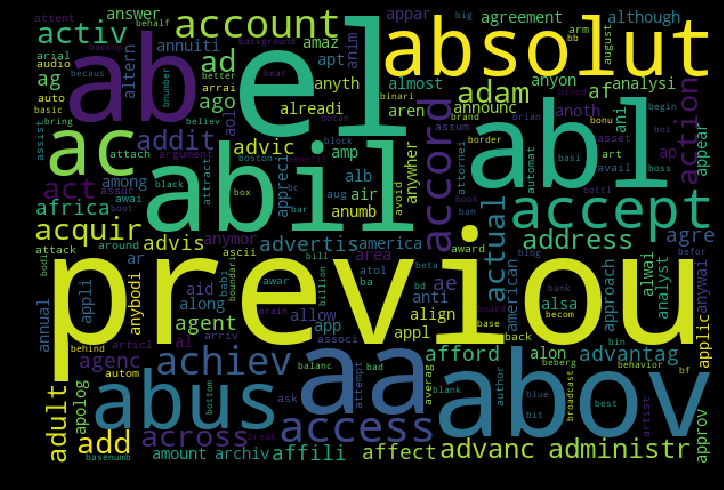

In [7]:
from wordcloud import WordCloud

vocab = get_vocabList()
spam_wordcloud = WordCloud(width=600, height=400).generate(" ".join(vocab))
plt.figure( figsize=(10,8), facecolor='k')
plt.imshow(spam_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

### Process emails separately

In [8]:
emails = pd.read_csv('emails.csv')
vocab = get_vocabList()
X = emails.iloc[:, 0]
y = emails.iloc[:, 1]
X_rec = np.zeros((X.shape[0], len(vocab)))

# process each mail separately
for m in range(len(X)):
    word_indices, original_email, vocabList, processed_email = process_email(X[m], is_file=False)
    feature = email_feature(word_indices, vocabList)
    X_rec[m, :] = feature

/home/pptr/.conda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  # Remove the CWD from sys.path while we load stuff.


## Logistic Regression

### Training 

In [9]:
testset_size = 1500
X_rec_train = X_rec[:(X_rec.shape[0] - testset_size)]
y_train = y[:(y.shape[0] - testset_size)]

X_rec_test = X_rec[(X_rec.shape[0] - testset_size):]
y_test = y[(X_rec.shape[0] - testset_size):]
X_rec_train.shape, y_train.shape, X_rec_test.shape, y_test.shape

((4228, 1899), (4228,), (1500, 1899), (1500,))

In [10]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0, solver='lbfgs')
m = clf.fit(X_rec_train, y_train)

### Testing model using test set

In [11]:
print("Accurcay: {0:.2f}".format((m.predict(X_rec_test) == y_test).sum()/X_rec_test.shape[0]*100), "%")

Accurcay: 98.87 %


## Neural Network

In [12]:
from keras.models import Sequential
from keras.layers import Dense
import numpy

# fix random seed for reproducibility
numpy.random.seed(7)

In [13]:
emails = pd.read_csv('emails.csv')
testset_size = 1500
X_rec_train = X_rec[:(X_rec.shape[0] - testset_size)]
y_train = y[:(y.shape[0] - testset_size)]

X_rec_test = X_rec[(X_rec.shape[0] - testset_size):]
y_test = y[(X_rec.shape[0] - testset_size):]

In [14]:
# create model
model = Sequential()
model.add(Dense(12, input_dim=1899, activation='relu'))
model.add(Dense(1899, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [15]:
# compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

### Training

In [16]:
model.fit(X_rec_train, y_train, epochs=10, batch_size=10)

Epoch 1/10
4228/4228 [==============================] - 1s 291us/step - loss: 0.1503 - acc: 0.9366
Epoch 2/10
4228/4228 [==============================] - 2s 546us/step - loss: 0.0326 - acc: 0.9917
Epoch 3/10
4228/4228 [==============================] - 2s 520us/step - loss: 0.0095 - acc: 0.9974
Epoch 4/10
4228/4228 [==============================] - 2s 531us/step - loss: 0.0039 - acc: 0.9986
Epoch 5/10
4228/4228 [==============================] - 2s 516us/step - loss: 0.0018 - acc: 0.9995
Epoch 6/10
4228/4228 [==============================] - 3s 647us/step - loss: 0.0015 - acc: 0.9998
Epoch 7/10
4228/4228 [==============================] - 2s 570us/step - loss: 0.0020 - acc: 0.9993
Epoch 8/10
4228/4228 [==============================] - 2s 535us/step - loss: 9.8202e-04 - acc: 0.9998
Epoch 9/10
4228/4228 [==============================] - 2s 533us/step - loss: 0.0023 - acc: 0.9993
Epoch 10/10
4228/4228 [==============================] - 2s 518us/step - loss: 0.0017 - acc: 0.9993


### Testing model using test set 

In [17]:
scores = model.evaluate(X_rec_test, y_test)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

1500/1500 [==============================] - 0s 126us/step

acc: 98.87%


## Testing using my email

In [18]:
my_email = 'mymail.txt'
word_indices, original_email, vocabList, processed_email = process_email(my_email, is_file=True)
X = email_feature(word_indices, vocabList)

/home/pptr/.conda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  # Remove the CWD from sys.path while we load stuff.


In [19]:
with open(my_email, 'r', encoding='ISO-8859-1') as myfile:
            processed_email = myfile.read()
processed_email

'This a spam email\n'

In [20]:
np.where(np.round(model.predict(X.reshape(-1,1).T)) == 1, "Spam", "Not spam")[0][0]

'Spam'